In [1]:
import os
import scipy.io
import math
import sklearn
import sklearn.datasets
import numpy as np
import scipy
from PIL import Image
from scipy import ndimage
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import time
%matplotlib inline
def imaget_to_pxl(path,size):
    zeros=np.zeros(shape=(64,64,3))
    img_to_pxls=[]
    img_to_pxls.append(zeros)
    img_name={'name':0}
    N=1
    start=time.time()
    #print img_to_pxls.shape
    for i in os.listdir(path):
        if i.endswith('.jpg'):
            new_size=(size,size)
            im = Image.open(path+i, 'r')#.resize(new_size)
            pixel_values = list(im.getdata())
            if im.mode == 'RGB':
                #pixel_values = np.array(pixel_values).reshape((size, size, 3))
                #plt.imshow(im)
                my_image = scipy.misc.imresize(im, size=new_size)#.reshape((1,-1))
                #plt.imshow(my_image)
                img_to_pxls.append(my_image) 
                
                img_name[i.split('.')[0]]=N
                N +=1
                if N == 2000:
                    print(N)
                    break
               
                #print img_to_pxls.shape
            else:
                print('Skipped the file %s because of incorrect mode' %(i))
                continue  
        
        else:
            if i == "labels.csv":
                labels_dic = pd.Series.from_csv(path+i).to_dict()
            else:
                print('Skipped the file %s because of incorrect extension' %(i))
    labels_dic = pd.Series.from_csv(path+'labels.csv').to_dict()        
    print('time elapsed')
    print(time.time()-start)
    print('conversion complete')       
    return img_to_pxls,img_name,labels_dic

In [2]:
img_pxls,iname,lbls=imaget_to_pxl('/home/balaji/Downloads/balaji/dogs/train/',64)

2000
time elapsed
178.890779972
conversion complete


In [3]:
def input_ouput_map(itp,inam,lbs):
    j=1
    lbl_numbering={}
    lbl_reassign={}
    input_out_map={}
    for i in sorted(set(lbs.values())):
        lbl_numbering[i]=j
    #print i
        j+=1
    for k,v in lbs.items():
        lbl_reassign[k]=lbl_numbering[v]
    
    for ipu,num in inam.items():
        if ipu=='name':
            continue
        else:
            #print ipu
            input_out_map[num]=lbl_reassign[ipu]
         
    yb4=[i for i in input_out_map.values()]
    yb4.insert(0,0)
    Y=np.array(yb4)
    xb4=np.array(itp)
    xb4= xb4.reshape(xb4.shape[0],xb4.shape[1]*xb4.shape[2]*3)
    X=xb4.T
    return X, Y
    

In [6]:
X,Y= input_ouput_map(img_pxls,iname,lbls)
print X.shape
print Y.shape

(12288, 2000)
(2000,)


In [4]:

def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    
    ### START CODE HERE ###
    
    # Create a tf.constant equal to C (depth), name it 'C'. (approx. 1 line)
    C = tf.constant(C)
    
    # Use tf.one_hot, be careful with the axis (approx. 1 line)
    one_hot_matrix = tf.one_hot(labels, C, axis=0) 
    
    # Create the session (approx. 1 line)
    sess = tf.Session()
    
    # Run the session (approx. 1 line)
    one_hot = sess.run(one_hot_matrix)
    
    # Close the session (approx. 1 line). See method 1 above.
    sess.close()
    
    ### END CODE HERE ###
    
    return one_hot

In [7]:
X_train = X/255.

Y_train = one_hot_matrix(Y.T, 122)
print X_train.shape
print Y_train.shape

(12288, 2000)
(122, 2000)


In [8]:
def create_placeholders(n_x, n_y):

    X = tf.placeholder(tf.float32,[n_x,None])
    Y = tf.placeholder(tf.float32,[n_y,None])
    
    return X, Y

In [9]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [968, 12288]
                        b1 : [968, 1]
                        W2 : [484, 968]
                        b2 : [484, 1]
                        W3 : [242, 488]
                        b3 : [242, 1]
                        W4 : [121, 242
                        b4 : [121, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
    tf.get_variable_scope().reuse == False   
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 =  tf.get_variable("W1", [976,12288], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [976,1], initializer = tf.zeros_initializer())
    W2 =  tf.get_variable("W2", [488,976], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [488,1], initializer = tf.zeros_initializer())
    W3 =  tf.get_variable("W3", [244,488], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [244,1], initializer = tf.zeros_initializer())
    W4 =  tf.get_variable("W4", [122,244], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b4 = tf.get_variable("b4", [122,1], initializer = tf.zeros_initializer())
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                  "W4": W4,
                  "b4": b4,
                 }
    
    return parameters

In [10]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1,X),b1)                                              # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                               # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)                                                # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                               # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)                                                # Z3 = np.dot(W3,Z2) + b3
    A3 = tf.nn.relu(Z3)                                               # A2 = relu(Z2)
    Z4 = tf.add(tf.matmul(W4,A3),b4)                                                # Z3 = np.dot(W3,Z2) + b3
    
    ### END CODE HERE ###
    #print('Z3-shape')
   # print(Z3.shape)
    return Z4

In [11]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z4, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z4)
    labels = tf.transpose(Y)
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    ### END CODE HERE ###
    
    return cost

In [12]:

def random_mini_batches(X, Y, mini_batch_size , seed ):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    #print permutation
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]#.reshape((1,m))
    #print(math.floor(m/mini_batch_size))
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(math.floor(m/mini_batch_size)) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X [:, k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y [:, k*mini_batch_size:(k+1)*mini_batch_size]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        ### START CODE HERE ### (approx. 2 lines)
        mini_batch_X = shuffled_X [:, mini_batch_size* num_complete_minibatches:m]
        mini_batch_Y = shuffled_Y [:, mini_batch_size* num_complete_minibatches:m]
        ### END CODE HERE ###
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [13]:
def model(X_train, Y_train, learning_rate = 0.0001,
          num_epochs = 500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    tf.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    print('balaji')
    X, Y =  create_placeholders(n_x, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    print('balaji2')
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    print('balaji3')
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    print('balaji4')
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    print('balaji5')
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        rset_timer = 0
        # Do the training loop
        for epoch in range(num_epochs):
           # print('balaji6')
            if rset_timer == 0:
                rset_timer=1
                #print('epoch %s start' %epoch)
                batch_start=time.time()
                
            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            #print(seed)
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                #print('balaji7')
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
               # print(minibatch_Y.shape)
               # print(minibatch_X.shape)
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 10 == 0:
                rset_timer=0
                print ('batch  took %s secs' %(time.time()-batch_start))
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        #print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

balaji
balaji2
balaji3
balaji4
balaji5
batch  took 24.66051507 secs
Cost after epoch 0: 4.950508
batch  took 214.219896078 secs
Cost after epoch 10: 4.315650
batch  took 211.060575008 secs
Cost after epoch 20: 3.545280
batch  took 211.714886904 secs
Cost after epoch 30: 2.601936
batch  took 207.909774065 secs
Cost after epoch 40: 1.701248
batch  took 208.170145035 secs
Cost after epoch 50: 0.967579
batch  took 207.887019157 secs
Cost after epoch 60: 0.554288
batch  took 207.95254612 secs
Cost after epoch 70: 0.257348
batch  took 207.943392992 secs
Cost after epoch 80: 0.118323
batch  took 208.329560995 secs
Cost after epoch 90: 0.063570
batch  took 209.009554863 secs
Cost after epoch 100: 0.041417
batch  took 208.267743111 secs
Cost after epoch 110: 0.046091
batch  took 210.343430042 secs
Cost after epoch 120: 0.056844
batch  took 208.052819014 secs
Cost after epoch 130: 0.022257
batch  took 207.947237015 secs
Cost after epoch 140: 0.015978
batch  took 208.033723831 secs
Cost after epo

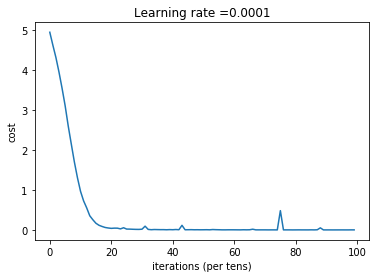

Parameters have been trained!
('Train Accuracy:', 0.99900001)


In [14]:
parameters = model(X_train, Y_train)